# Notebook to debug Model training

In [40]:
import os
import argparse
import torch
import torchvision

import numpy as np
import smdebug.pytorch as smd
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms


TRAIN ='train'
VALIDATION = 'val'
TEST = 'test'

MAX_SAMPLES_PROPORTION = 0.1
THESHOLD_LOGGING_SAMPLES = 20

def log_metrics(loss, running_corrects, running_samples, total_samples):
    accuracy = running_corrects / running_samples
    print("Images [{}/{} ({:.0f}%)] Loss: {:.2f} Accuracy: {}/{} ({:.2f}%)".format(
        running_samples,
        total_samples,
        100.0 * (running_samples / total_samples),
        loss.item(),
        running_corrects,
        running_samples,
        100.0 * accuracy,
        )
    )
    
def test(model, test_loader, criterion, hook):
    print(f"Testing Model on {MAX_SAMPLES_PROPORTION*100}% of the Dataset")
    model.eval()
    hook.set_mode(smd.modes.EVAL)
    running_loss = 0
    running_corrects = 0
    running_samples = 0
    total_samples = len(test_loader.dataset)

    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        running_samples += len(inputs)
        
        #NOTE: Comment lines below to train and test on whole dataset
        if running_samples > (MAX_SAMPLES_PROPORTION * total_samples):
            break

    total_loss = running_loss / len(test_loader.dataset)
    total_acc = running_corrects / len(test_loader.dataset)
    print(f"Testing Loss: {total_loss:.2f}, Testing Accuracy: {100*total_acc:.2f}")


def validate(model, validation_loader, criterion):
    model.eval()
    running_loss = 0
    running_corrects = 0
    running_samples = 0
    total_samples = len(validation_loader.dataset)

    for inputs, labels in validation_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        running_samples += len(inputs)
        if running_samples % THESHOLD_LOGGING_SAMPLES == 0:
            log_metrics(loss, running_corrects, running_samples, total_samples)
            
        #NOTE: Comment lines below to train and test on whole dataset
        if running_samples > (MAX_SAMPLES_PROPORTION * total_samples):
            break

    epoch_loss = running_loss / running_samples
    epoch_acc = running_corrects / running_samples
    print(f"Phase validation, Epoc loss {epoch_loss:.2f}, Epoc accuracy {100*epoch_acc:.2f}")
    return epoch_loss


def train(model, train_loader, criterion, optimizer, hook):
    model.train()
    hook.set_mode(smd.modes.TRAIN)

    running_loss = 0.0
    running_corrects = 0
    running_samples = 0
    total_samples = len(train_loader.dataset)

    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        running_samples += len(inputs)
        if running_samples % THESHOLD_LOGGING_SAMPLES == 0:
            log_metrics(loss, running_corrects, running_samples, total_samples)

        #NOTE: Comment lines below to train and test on whole dataset
        if running_samples > (MAX_SAMPLES_PROPORTION * total_samples ):
            break

    epoch_loss = running_loss / running_samples
    epoch_acc = running_corrects / running_samples
    print(f"Phase training, Epoc loss {epoch_loss:.2f}, Epoc accuracy {100*epoch_acc:.2f}")
    return epoch_loss

def train_with_early_stopping(model, datasets_loader, epochs, loss_criterion, optimizer, hook):
    best_loss = 1e6
    print(f"Training Model on {MAX_SAMPLES_PROPORTION*100}% of the Dataset")
    
    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch} ...")
        _ = train(model, datasets_loader[TRAIN], loss_criterion, optimizer, hook)
        validate_epoch_loss = validate(model, datasets_loader[VALIDATION], loss_criterion)
        print(validate_epoch_loss, best_loss)
        if validate_epoch_loss < best_loss:
            best_loss = validate_epoch_loss
        else:
            print('Loss of validation model started to increase')
            break

def net(num_classes: int):
    '''Initializes a pretrained model'''
    model = models.resnet50(pretrained=True)

    # Freeze training of the convolutional layers
    for param in model.parameters():
        param.requires_grad = False   

    # Override the last layer to adjust it to our problem
    num_features=model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, num_classes)
    )
    
    return model

def create_data_loaders(train_data_dir: str, valid_data_dir: str, test_data_dir: str, batch_size: int):
    '''Create pytorch data loaders'''
     
    data_dir = {TRAIN: train_data_dir, VALIDATION: valid_data_dir, TEST: test_data_dir}
    
    transform_steps = [ 
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    
    data_transforms = {
        TRAIN: transforms.Compose([ transforms.RandomHorizontalFlip(), *transform_steps]),
        VALIDATION: transforms.Compose(transform_steps),
        TEST: transforms.Compose(transform_steps)
    }
   
    image_datasets = {}
    dataloaders = {}
    for x in [TRAIN, VALIDATION, TEST]:
        
        image_datasets[x] = torchvision.datasets.ImageFolder(data_dir[x], data_transforms[x])
        dataloaders[x] = torch.utils.data.DataLoader(
            image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2)
        
    return dataloaders

def get_num_classes(dataloader) -> int:
        return len(dataloader[TRAIN].dataset.classes)
    
def save_model(model, model_dir):
    path = os.path.join(model_dir, "model.pth")
    print("Saving the model to path {path}")
    torch.save(model.state_dict(), path)
    
    
def model_fn(model_dir):
    model = Net()
    with open(os.path.join(model_dir, "model.pth"), "rb") as f:
        model.load_state_dict(torch.load(f))
    return model

def main(args):
    
    dataset_loaders = create_data_loaders(args.data_dir_train, args.data_dir_validation, args.data_dir_test, args.batch_size)
    
    num_classes = get_num_classes(dataset_loaders)
    model=net(num_classes)
    loss_criterion = nn.CrossEntropyLoss()
    optimizer =  optim.Adam(model.fc.parameters(), lr=args.lr)
    
    
    hook = smd.Hook.create_from_json_file() # just added
    hook.register_hook(model) # just added
    
    train_with_early_stopping(model, dataset_loaders, args.epochs, loss_criterion, optimizer, hook) 
    test(model, dataset_loaders[TEST], loss_criterion, hook) 
         
    save_model(model, args.model_dir)



if __name__=='__main__':
    parser=argparse.ArgumentParser(description="Training Job for Hyperparameter tuning")
    
    parser.add_argument(
        "--batch-size",
        type=int,
        default=64,
        metavar="N",
        help="input batch size for training (default: 64)",
    )

    parser.add_argument(
        "--epochs",
        type=int,
        default=14,
        metavar="N",
        help="number of epochs to train (default: 14)",
    )
    parser.add_argument(
        "--lr", type=float, default=1.0, metavar="LR", help="learning rate (default: 1.0)"
    )

    
    # Container environment
    
#     parser.add_argument("--hosts", type=list, default=json.loads(os.environ["SM_HOSTS"]))
#     parser.add_argument("--current-host", type=str, default=os.environ["SM_CURRENT_HOST"])
    parser.add_argument("--model-dir", type=str, default=os.environ["SM_MODEL_DIR"])
    parser.add_argument("--data-dir-train", type=str, default=os.environ["SM_CHANNEL_TRAINING"])
    parser.add_argument("--data-dir-test", type=str, default=os.environ["SM_CHANNEL_TESTING"])
    parser.add_argument("--data-dir-validation", type=str, default=os.environ["SM_CHANNEL_VALIDATION"])
#     parser.add_argument("--num-gpus", type=int, default=os.environ["SM_NUM_GPUS"])
    
    args = parser.parse_args()
    
    main(args)

In [ ]:
! ls /opt/ml/input/config

## TEST

### Arguments

In [28]:
import sys
import os

sys.argv = ["hpo.py", "--batch-size", "32", "--lr", "0.001", "--epochs", "2"]

os.environ['SM_CHANNEL_TRAINING'] = "../project-files/dogImages/train"
os.environ['SM_CHANNEL_VALIDATION'] = "../project-files/dogImages/valid"
os.environ['SM_CHANNEL_TESTING'] = "../project-files/dogImages/test"
os.environ['SM_MODEL_DIR'] = "/opt/ml/model"

# ! mkdir /opt/ml/model
# ! chown -R ec2-user:ec2-user /opt/ml/model # give ownership to the current EC2 user

! mkdir /opt/ml/model
! chown -R 1000:1000 /opt/ml/model

! mkdir /opt/ml/input
! mkdir /opt/ml/input/config
! cp ./profilerconfig.json /opt/ml/input/config/
! cp ./debughookconfig.json /opt/ml/input/config/

mkdir: cannot create directory ‘/opt/ml/model’: File exists
mkdir: cannot create directory ‘/opt/ml/input’: File exists
mkdir: cannot create directory ‘/opt/ml/input/config’: File exists


### Data loaders

In [47]:
%matplotlib inline

import matplotlib.pyplot as plt

data_loaders = create_data_loaders("./dogImages/test", "./dogImages/test", 30)

In [48]:
data_loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fe9fdc2a4a8>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fe9fc6baf98>}

Checking one batch:

In [49]:
batch = next(iter(data_loaders['train']))

In [50]:
batch[0].shape,  batch[1].shape

(torch.Size([30, 3, 224, 224]), torch.Size([30]))

This batch contains 30 images, with 3 channels, and each image is of size 224 by 224. There are 30 labels associated to each image.

Checking one image (and the transformation):

In [51]:
batch[0][0].shape, batch[0][0].permute(1, 2, 0).shape

(torch.Size([3, 224, 224]), torch.Size([224, 224, 3]))

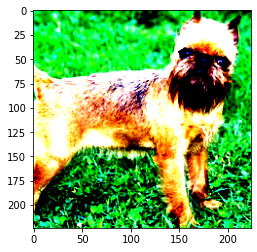

In [52]:
image = batch[0][0].permute(1, 2, 0)
breed = batch[1][0]

plt.imshow(image);

In [53]:
breed

tensor(37)

In [54]:
!ls ./dogImages/test/0{breed + 1}.*

Brussels_griffon_02656.jpg  Brussels_griffon_02701.jpg
Brussels_griffon_02667.jpg  Brussels_griffon_02707.jpg
Brussels_griffon_02678.jpg  Brussels_griffon_02716.jpg
Brussels_griffon_02699.jpg


### Model 

In [57]:
num_classes =len( data_loaders['train'].dataset.classes)
num_classes

133

In [58]:
model = net(num_classes) #If it complain, specify the weights based on the official documentation
type(model)

torchvision.models.resnet.ResNet

In [60]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 